In [1]:
# Run this cell in your notebook to install the required packages
!pip install tensorflow numpy matplotlib
%pip install torch torchvision opencv-python pillow numpy matplotlib scikit-learn tqdm

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.17.0-cp312-cp312-win_amd64.whl.metadata (34 kB)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16 # We will use VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [5]:
# --- Define Your Parameters ---
IMG_SIZE = 224 # VGG16 model expects 224x224 images
BATCH_SIZE = 32

# --- Set Your File Paths ---
# !! Change these to your actual folder paths !!
BASE_DIR = 'Lung Cancer Detection/'
TRAIN_DIR = r"C:\Users\dvrre\Downloads\Lung cancer detection\train"
VALID_DIR = r"C:\Users\dvrre\Downloads\Lung cancer detection\valid"
TEST_DIR = r"C:\Users\dvrre\Downloads\Lung cancer detection\test"

# --- Load the Data ---
# Keras will automatically find the subfolders (adenocarcinoma, etc.)
# and label them for you (e.g., 0, 1, 2...)

print("Loading training data...")
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int' # Labels will be integers (0, 1, 2...)
)

print("\nLoading validation data...")
valid_dataset = image_dataset_from_directory(
    VALID_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

print("\nLoading test data...")
test_dataset = image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# --- Get Class Names ---
class_names = train_dataset.class_names
print(f"\nFound classes: {class_names}")
NUM_CLASSES = len(class_names)

# --- Optimize Data Loading ---
# This helps the model run faster by pre-fetching data
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Loading training data...
Found 611 files belonging to 4 classes.

Loading validation data...
Found 72 files belonging to 4 classes.

Loading test data...
Found 315 files belonging to 4 classes.

Found classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [6]:
# --- Load the Base Model (VGG16) ---
# We load it without its original classification layers (include_top=False)
# 'imagenet' weights are the pre-trained weights
base_model = VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# --- Freeze the Base Model ---
# We tell Keras "don't update the weights of these layers"
base_model.trainable = False

# --- Add Our Custom Layers ---
# This is the new "head" of our model
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# We need to scale the pixel values to what VGG16 expects
x = tf.keras.applications.vgg16.preprocess_input(inputs)

# Run the frozen base model
x = base_model(x, training=False) 

# Add our new layers
x = GlobalAveragePooling2D()(x) # Condenses the features
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Helps prevent overfitting
outputs = Dense(NUM_CLASSES, activation='softmax')(x) # Softmax for multi-class

# --- Create the Final Model ---
model = Model(inputs, outputs)

# --- Compile the Model ---
# Use 'sparse_categorical_crossentropy' because our labels are integers
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 71s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# --- Define Callbacks ---
best_model_path = "lung_cancer_classifier.keras"
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                             patience=5, # Stop if no improvement after 5 epochs
                             restore_best_weights=True)

# --- Start Training ---
EPOCHS = 20 # We don't need as many epochs for transfer learning

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint, early_stopping]
)

print("Training finished. Best model saved to 'lung_cancer_classifier.keras'")

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3251 - loss: 5.4326
Epoch 1: val_loss improved from None to 1.82390, saving model to lung_cancer_classifier.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.3290 - loss: 4.9214 - val_accuracy: 0.4306 - val_loss: 1.8239
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3446 - loss: 3.9274
Epoch 2: val_loss improved from 1.82390 to 1.51588, saving model to lung_cancer_classifier.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.3682 - loss: 3.8407 - val_accuracy: 0.5278 - val_loss: 1.5159
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4346 - loss: 2.9419
Epoch 3: val_loss improved from 1.51588 to 1.26956, saving model to lung_cancer_classifier.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.4452 - loss: 2.8915 - val_accuracy: 0.5278 - val_loss: 1.2696
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4651 - loss: 2.6139
Epoch 4: val_loss improved from 1


Evaluating model on test data...
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.6889 - loss: 0.7175
Test Loss:     0.7175
Test Accuracy: 68.89%


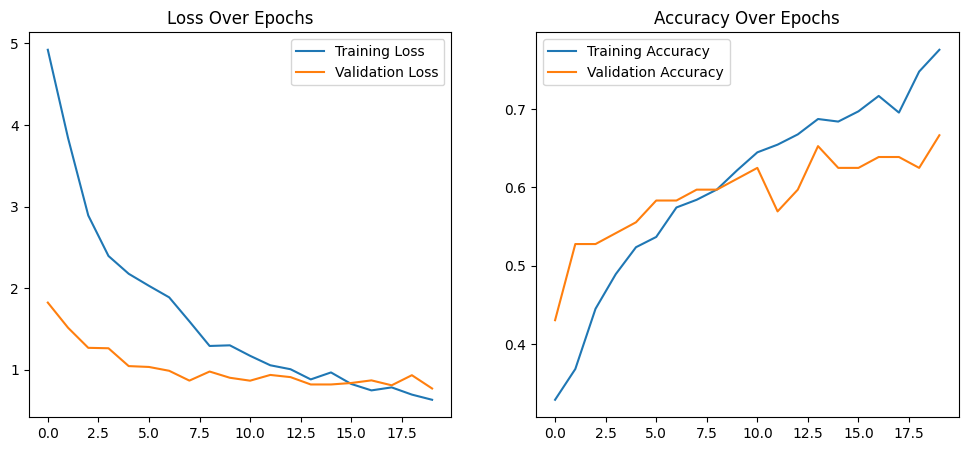


Visualizing predictions on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


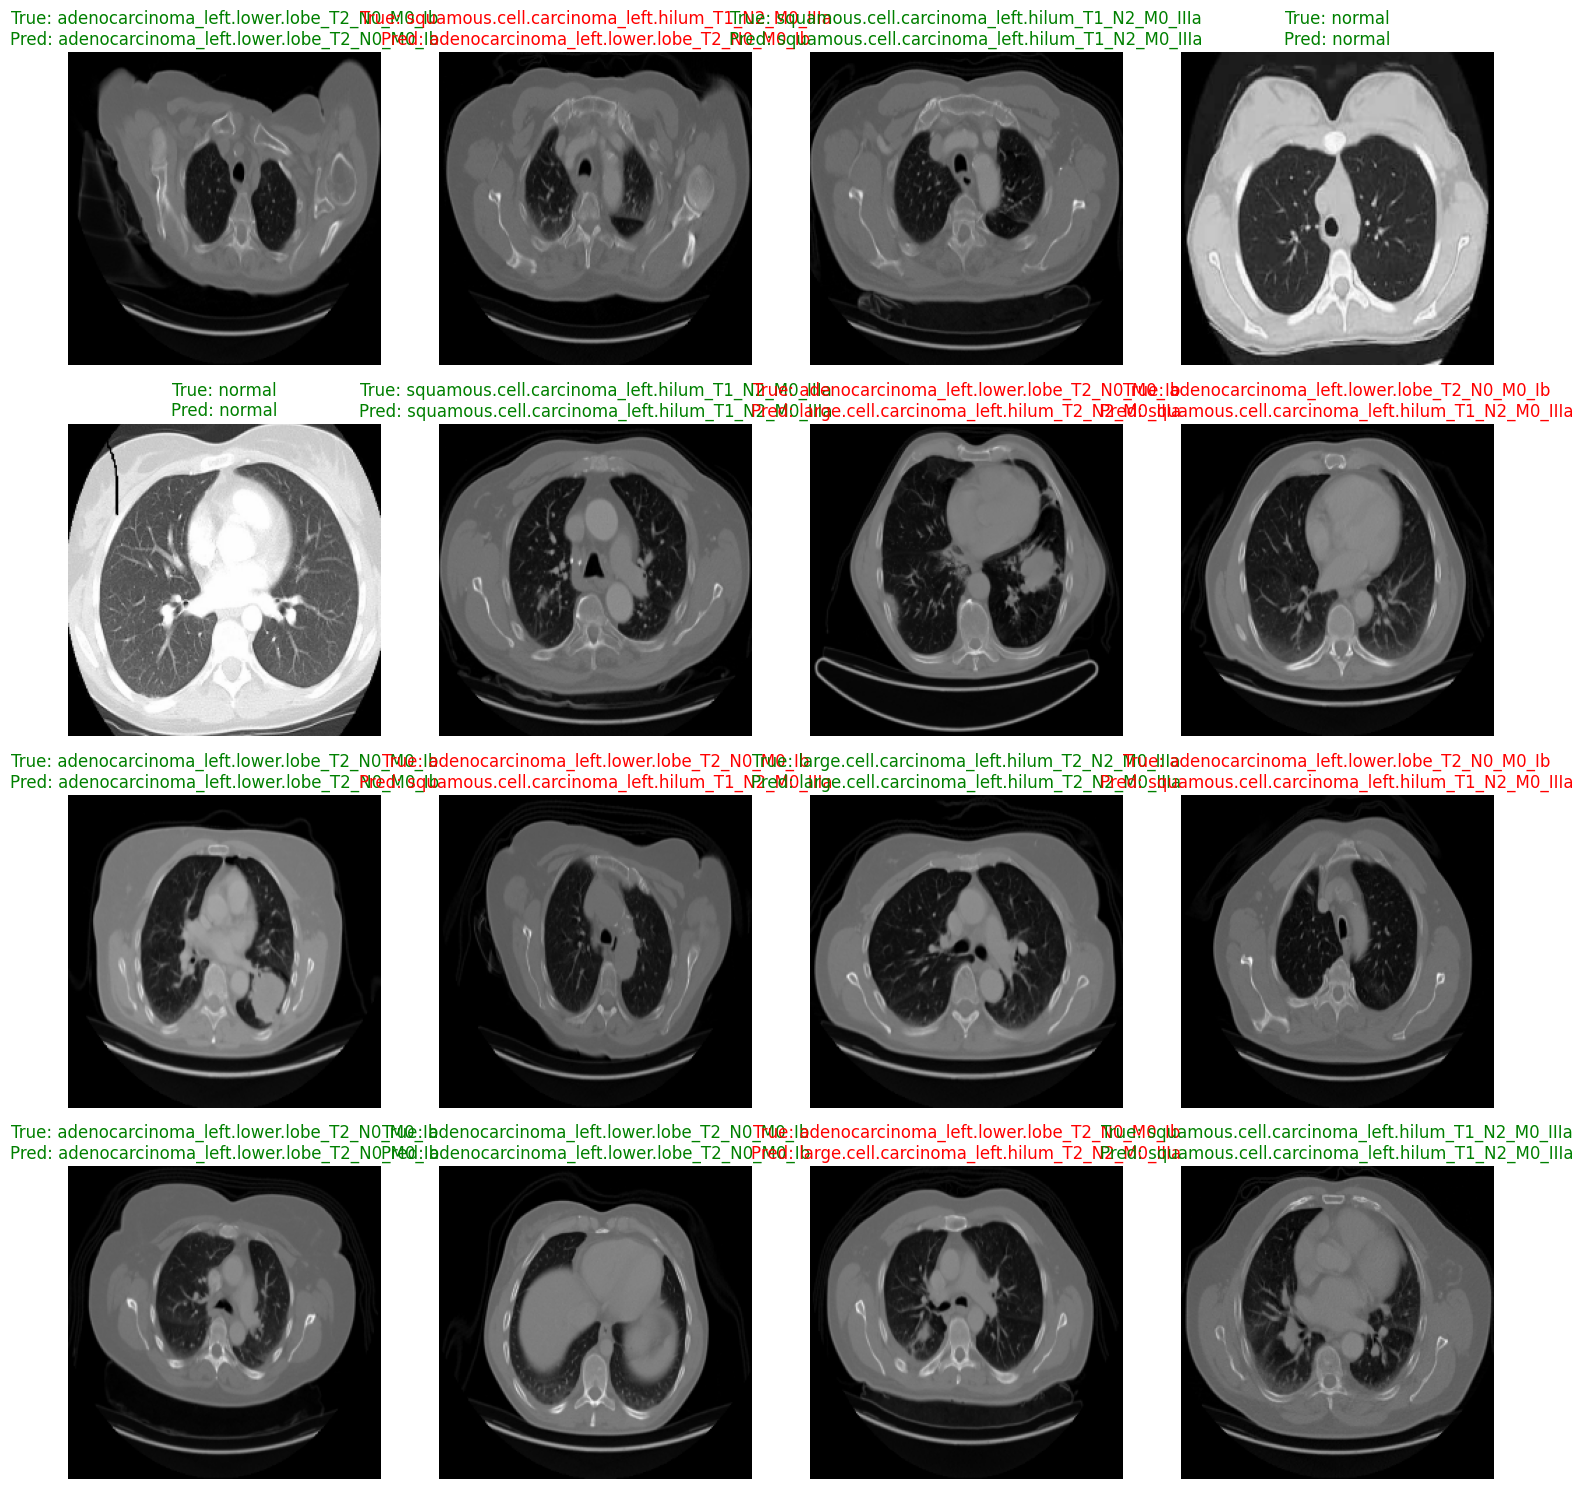

In [8]:
# --- Load the best saved model ---
model.load_weights(best_model_path)

# --- Evaluate on Test Data ---
print("\nEvaluating model on test data...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# --- Visualize Predictions ---
print("\nVisualizing predictions on test data...")
plt.figure(figsize=(15, 15))

# Take one batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    
    for i in range(16): # Show first 16 images in the batch
        if i >= len(images):
            break # Avoid error if batch is smaller than 16
            
        ax = plt.subplot(4, 4, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Get true and predicted labels
        true_label = class_names[labels[i]]
        pred_label = class_names[np.argmax(predictions[i])]
        
        # Set title color
        color = "green" if true_label == pred_label else "red"
        
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
        
plt.tight_layout()
plt.show()